In [1]:
import os
import json
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from pathlib import Path

In [2]:
ds = load_dataset("google/MusicCaps")
df_train = ds['train'].to_pandas()
df_train['aspect_list_transformed'] = df_train['aspect_list'].apply(ast.literal_eval)

In [3]:
tag_counts = {}
for aspects in df_train['aspect_list_transformed']:
    for tag in aspects:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)

/tmp/ipykernel_40686/592743751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')


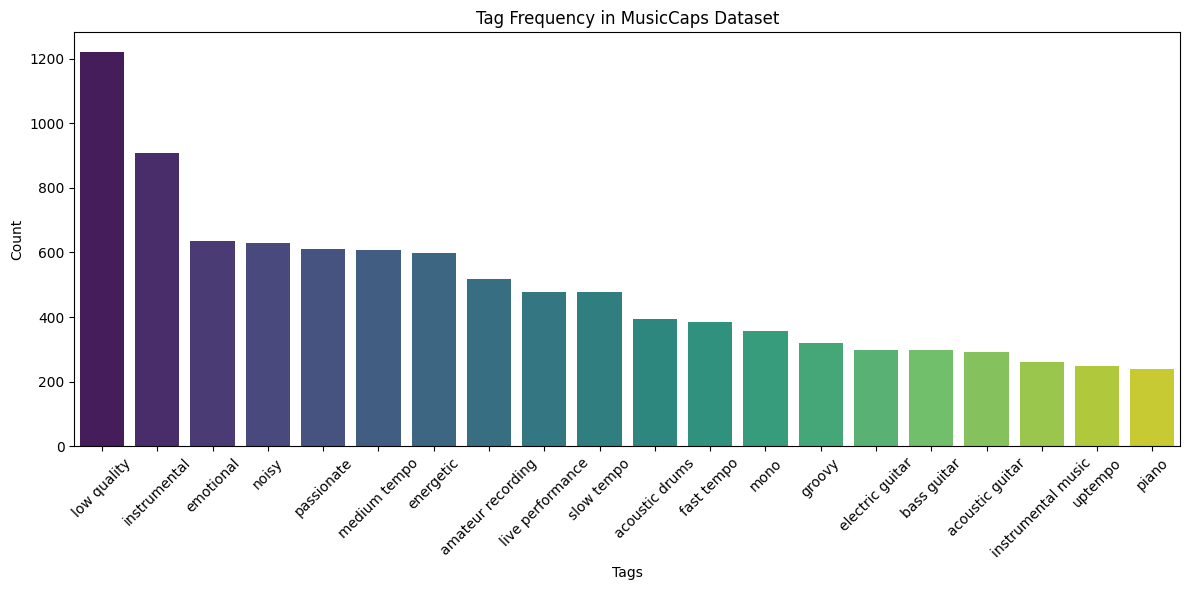

In [4]:
_tag_counts_df = tag_counts_df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Tag Frequency in MusicCaps Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
tag_counts_df.to_csv("../data/musiccaps_tag_frequencies.csv", index=False)

In [3]:
def extract_tags(song_tags, concept_tags):
    res = []
    for c_tag in concept_tags:
        for s_tag in song_tags:
            if c_tag in s_tag:
                res.append(s_tag)
    return list(set(res))

In [5]:
concepts = json.load(open("../data/concepts_to_tags.json", "r"))

for concept, tags in concepts.items():
    df_train[concept + '_tags'] = df_train['aspect_list_transformed'].apply(
        lambda x: extract_tags(x, tags)
    )

In [6]:
df_train = df_train[["caption", "aspect_list_transformed", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train = df_train[(df_train['tempo_tags'].map(len) > 0) & 
                    (df_train['genre_tags'].map(len) > 0) & 
                    (df_train['mood_tags'].map(len) > 0) & 
                    (df_train['instrument_tags'].map(len) > 0)] 
df_train["aspect_list"] = df_train["aspect_list_transformed"].apply(lambda x: ', '.join(x))
df_train["tempo_tags"] = df_train["tempo_tags"].apply(lambda x: ', '.join(x))
df_train["genre_tags"] = df_train["genre_tags"].apply(lambda x: ', '.join(x))
df_train["mood_tags"] = df_train["mood_tags"].apply(lambda x: ', '.join(x))
df_train["instrument_tags"] = df_train["instrument_tags"].apply(lambda x: ', '.join(x))
df_train = df_train[["caption", "aspect_list", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
11,This folk song features a male voice singing t...,"folk music, rubab, male voice, slow tempo, emo...",slow tempo,folk music,emotional song,"accordion, male voice, violin"
15,This is an R&B/soul music piece. There is a ma...,"r&b, soul, male vocal, melodic singing, string...",groovy,"soul, electronic drums, r&b",sensual,"male vocal, electronic drums, strong bass, str..."
19,A children’s choir sings this devotional melod...,"gospel music, poor sound quality, children cho...","medium tempo, groovy bass line, christian cont...","gospel music, black gospel music","inspiring, meditative","groovy bass line, keyboard harmony, steady dru..."
21,The Alternative/Indie song features an intimat...,"intimate wide mixed vocals, synth lead melody,...",groovy bass guitar,alternative/indie,melancholic,"claps, synth lead melody, punchy kick, electri..."
22,This is a Hindustani classical music piece. Th...,"hindustani classical music, harmonium, bansuri...",upbeat,"electronic drums, hindustani classical music",joyful,"electronic drums, tabla"
...,...,...,...,...,...,...
5507,A male vocalist sings this energetic song. The...,"male vocalist, medium tempo, spirited, scuffl...",medium tempo,rock,energetic drumming,"male vocalist, female voice talking"
5508,This is a hard rock clip with a metallic elect...,"four on the floor, slow tempo, rock, metallic ...",slow tempo,"hard rock, metallic electric guitar riff, rock...",hard rock,metallic electric guitar riff
5509,This dance song features a female voice singin...,"dance song, club song, whistling sound, techno...",moderate tempo,"techno beat, dance song",happy mood,"female voice, programmed percussion, synth sou..."
5517,The song is an instrumental. The song is mediu...,"instrumental music, arabic music, generational...",medium tempo,"folk musicians, ancient folk music, folk music...","passionate, emotional",percussion instruments


In [7]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

In [8]:
# Create output directory
output_dir = Path("../data/tags")
output_dir.mkdir(parents=True, exist_ok=True)

df_train.to_csv(output_dir / "train.csv", index=False)
df_valid.to_csv(output_dir / "validation.csv", index=False)
df_test.to_csv(output_dir / "test.csv", index=False)
all_df = pd.concat([df_train, df_valid, df_test])
all_df.to_csv(output_dir / "all.csv", index=False)

In [10]:
data_files = {
    "train": str(output_dir / "train.csv"),
    "validation": str(output_dir / "validation.csv"),
    "test": str(output_dir / "test.csv")
}
dataset = load_dataset("csv", data_files=data_files)
dataset.push_to_hub("bsienkiewicz/musiccaps-tags-to-caption", private=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption/commit/788f21b192e6558e01c0fe6827bc3bcf8149257a', commit_message='Upload dataset', commit_description='', oid='788f21b192e6558e01c0fe6827bc3bcf8149257a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/musiccaps-tags-to-caption'), pr_revision=None, pr_num=None)